In [1]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import BQuarterBegin
import scipy.stats as stats
from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt
import seaborn as sns

import os
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import power_transform


%matplotlib inline
plt.rcParams.update({'font.size': 15})
plt.style.use('bmh')
sns.set_palette('colorblind')

## Creating some helper functions that will help with capturing a linear trend by fitting a simple linear model

In [19]:
def make_design_matrix(arr):
    """Construct a design matrix from a numpy array, converting to a 2-d array
    and including an intercept term."""
    return sm.add_constant(arr.reshape(-1, 1), prepend=False)

In [20]:
def fit_linear_trend(series):
    """Fit a linear trend to a time series.  Return the fit trend as a numpy array."""
    X = make_design_matrix(np.arange(len(series)) + 1)
    linear_trend_ols = sm.OLS(series.values, X).fit()
    linear_trend = linear_trend_ols.predict(X)
    return linear_trend

In [70]:
def plot_linear_trend(ax, name, series):
    linear_trend = fit_linear_trend(series)
    ax.plot(series.index.date, linear_trend)

## Reading in all the data

Let's read in all the data sources into separate dataframes at first

In [59]:
# reading in US later because columns are unnamed
charlotte_msa = pd.read_csv('../data/charlotte-concord-gastonia.csv')
denver_msa = pd.read_csv('../data/denver-aurora-lakewood.csv')
sf_msa = pd.read_csv('../data/sf-sm-redwoodcity.csv')
nashville_msa = pd.read_csv('../data/nashville-davidson-murfreesboro-franklin.csv')

These indices are hte best measure of true price changes in the housing market.

* index = benchmark value (stays more consistent relative to average and median prices)

* the index is a value price
    * ex: for january 1, 1977, the home value price is 40.23
    
* These data don't contain the attributes (features) of homes in the cities
        * just dates and value prices

## Creating us_df

In [60]:
# column names to use for all US df
cols = ['place_id', 'year', 'quarter', 'index']

all_us = pd.read_csv('../data/all-us.csv', names=cols)

# combining year and quarter columns and then changing format
all_us['year_quarter'] = all_us['year'].astype(str) + '-Q' + all_us['quarter'].astype(str)
all_us['year_quarter'] = pd.to_datetime(all_us['year_quarter'])
all_us.set_index(all_us['year_quarter'], inplace=True)

# creating separate US area df from dataframe
us_df = pd.DataFrame(all_us[all_us['place_id']=='USA'])

In [61]:
us_df.head()

,place_id,year,quarter,index,year_quarter
year_quarter,,,,,
1975-01-01,USA,1975,1,59.82,1975-01-01
1975-04-01,USA,1975,2,60.86,1975-04-01
1975-07-01,USA,1975,3,61.20,1975-07-01
1975-10-01,USA,1975,4,62.28,1975-10-01
1976-01-01,USA,1976,1,62.92,1976-01-01


In [62]:
all_us.head()

,place_id,year,quarter,index,year_quarter
year_quarter,,,,,
1975-01-01,DV_ENC,1975,1,63.69,1975-01-01
1975-04-01,DV_ENC,1975,2,62.59,1975-04-01
1975-07-01,DV_ENC,1975,3,63.63,1975-07-01
1975-10-01,DV_ENC,1975,4,64.99,1975-10-01
1976-01-01,DV_ENC,1976,1,64.88,1976-01-01


In [63]:
all_us['place_id'].value_counts()

DV_WSC    184
DV_MA     184
DV_PAC    184
DV_WNC    184
DV_NE     184
DV_ESC    184
USA       184
DV_ENC    184
DV_SA     184
DV_MT     184
Name: place_id, dtype: int64

getting a feel for what each dataset looks like

## Denver

In [64]:
denver_msa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DATE            179 non-null    object 
 1   ATNHPIUS19740Q  179 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.9+ KB


In [65]:
# renaming columns and changing date to datetime format and setting it as index

denver_msa.rename(columns={'DATE':'date','ATNHPIUS19740Q':'index'}, inplace=True)
denver_msa['date'] = pd.to_datetime(denver_msa['date'], infer_datetime_format = True)
denver_msa.set_index(denver_msa['date'], inplace=True)

In [66]:
denver_msa.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 179 entries, 1976-04-01 to 2020-10-01
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    179 non-null    datetime64[ns]
 1   index   179 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.2 KB


In [67]:
denver_msa.head()

,date,index
date,,
1976-04-01,1976-04-01,31.91
1976-07-01,1976-07-01,31.67
1976-10-01,1976-10-01,32.57
1977-01-01,1977-01-01,33.50
1977-04-01,1977-04-01,34.23


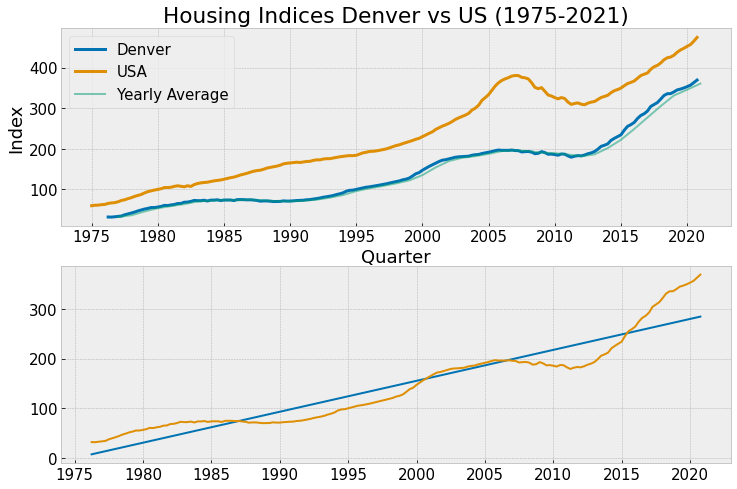

In [72]:
# Denver vs. USA

yearly = denver_msa['index'].resample('Y').mean()

fig, ax = plt.subplots(2, 1, figsize=(12,8))

ax[0].plot(denver_msa.index, denver_msa['index'], label="Denver", linewidth=3)
ax[0].plot(us_df.index, us_df['index'], label="USA", linewidth=3)
ax[0].plot(yearly, label='Yearly Average', alpha=0.5)
ax[0].set_xlabel('Quarter')
ax[0].set_ylabel('Index')
ax[0].set_title('Housing Indices Denver vs US (1975-2021)')
ax[0].legend()
plot_linear_trend(ax[1], 'Denver', denver_msa['index'])
ax[1].plot(denver_msa.index, denver_msa['index'])
plt.tight_layout;

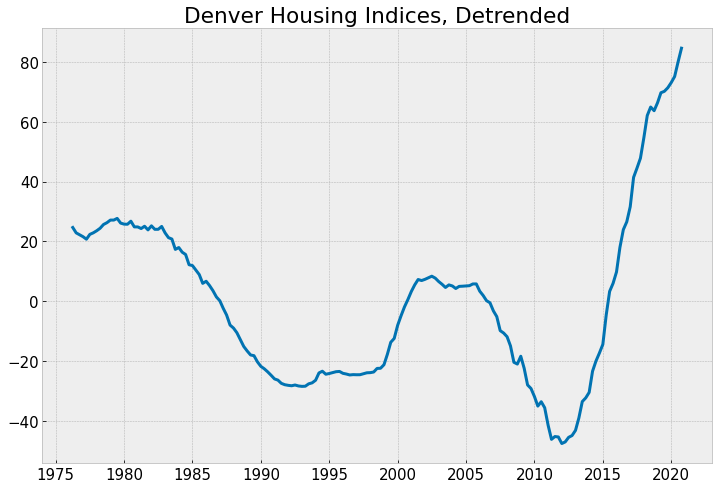

In [41]:
denver_series = denver_msa['index']
denver_linear_trend = fit_linear_trend(denver_series)

denver_series_detrended = denver_series - denver_linear_trend

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(denver_series_detrended.index, denver_series_detrended, linewidth=3)
ax.set_title('Denver Housing Indices, Detrended');

### Seasonal Decomposition

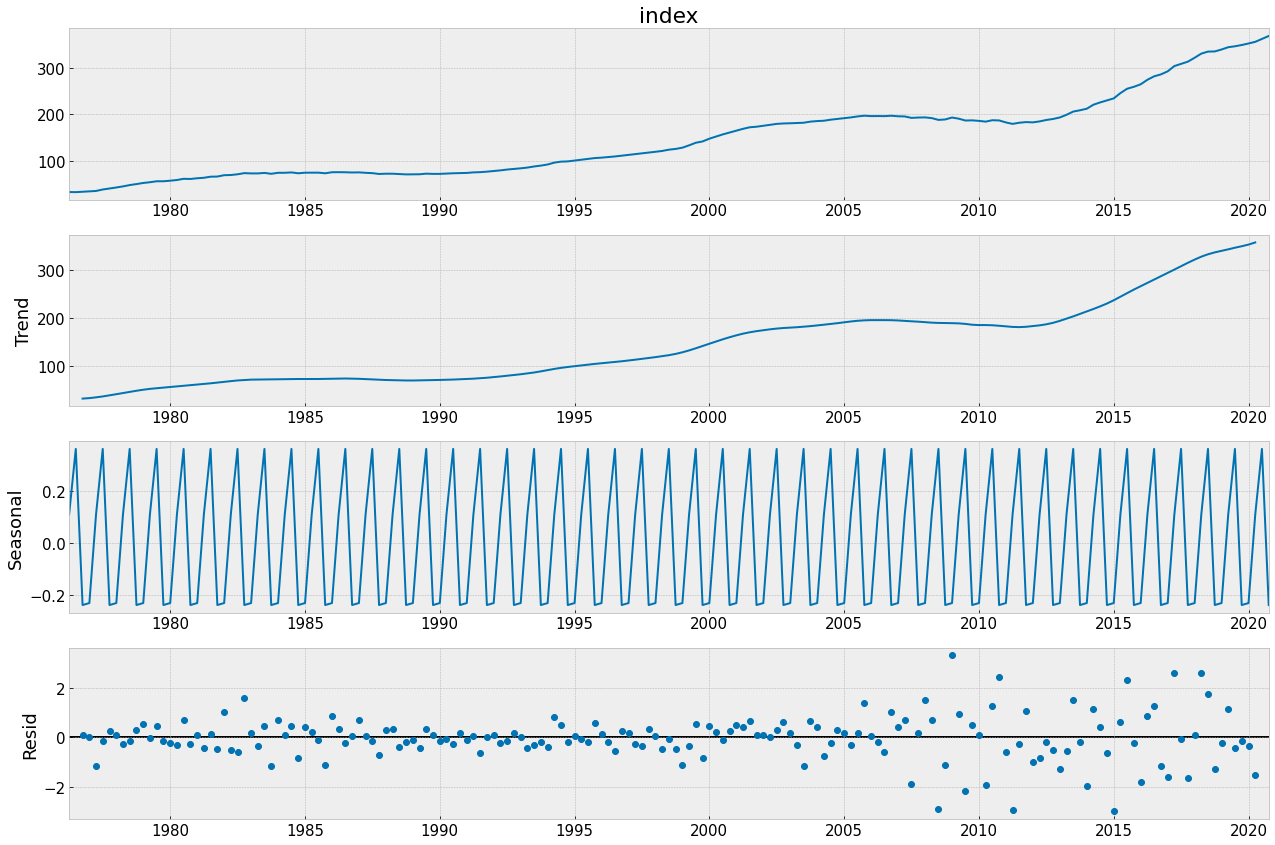

In [52]:
from pylab import rcParams

rcParams['figure.figsize'] = 18,12

decomp = seasonal_decompose(denver_msa['index'], model='additive')
decomp.plot();

Similar to the observed data, the trend component shows an overall upward trend.

There's definitely seasonality in the data. The indices are fluctuating every year by about 0.6

The residuals are heteroscedastic.

The data don't seem to be stationary.... but let's do a hypothesis test to confirm that via the `agumented Dickey-Fuller` test

Null: the data are non-stationary

Alternative: the observed data are stationary

In [42]:
result = adfuller(denver_msa['index'])

print(f'The p-value of the test is {result[1]}')

The p-value of the test is 0.9978526192335341


Based on the graphs above, which show a trend/seasonality component as well as a rather large p-value, we fail to reject the null-hypothesis. This means the observed data are not stationary.

## Charlotte

In [73]:
charlotte_msa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DATE            176 non-null    object 
 1   ATNHPIUS16740Q  176 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.9+ KB


In [74]:
# renaming columns

charlotte_msa.rename(columns={'DATE':'date','ATNHPIUS16740Q':'index'}, inplace=True)
charlotte_msa['date'] = pd.to_datetime(charlotte_msa['date'], infer_datetime_format = True)
charlotte_msa.set_index(charlotte_msa['date'], inplace=True)

In [75]:
charlotte_msa.head()

,date,index
date,,
1977-01-01,1977-01-01,40.23
1977-04-01,1977-04-01,36.82
1977-07-01,1977-07-01,40.09
1977-10-01,1977-10-01,42.39
1978-01-01,1978-01-01,43.67


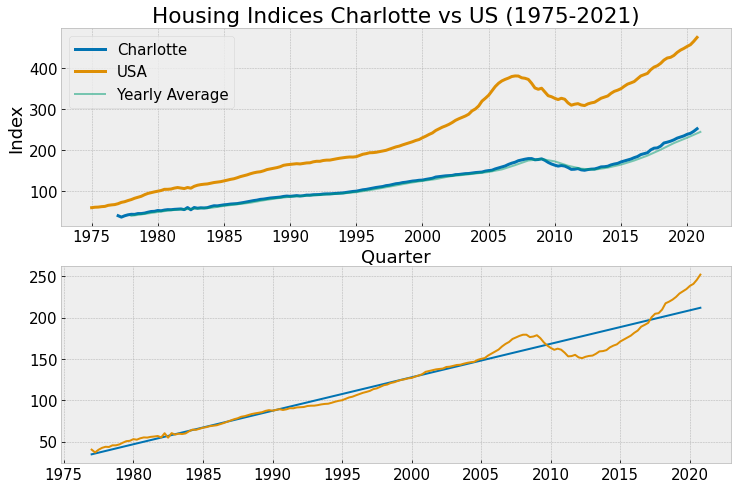

In [76]:
yearly = charlotte_msa['index'].resample('Y').mean()

fig, ax = plt.subplots(2, 1, figsize=(12,8))

ax[0].plot(charlotte_msa.index, charlotte_msa['index'], label="Charlotte", linewidth=3)
ax[0].plot(us_df.index, us_df['index'], label="USA", linewidth=3)
ax[0].plot(yearly, label='Yearly Average', alpha=0.5)
ax[0].set_xlabel('Quarter')
ax[0].set_ylabel('Index')
ax[0].set_title('Housing Indices Charlotte vs US (1975-2021)')
ax[0].legend()
plot_linear_trend(ax[1], 'Charlotte', charlotte_msa['index'])
ax[1].plot(charlotte_msa.index, charlotte_msa['index'])
plt.tight_layout;

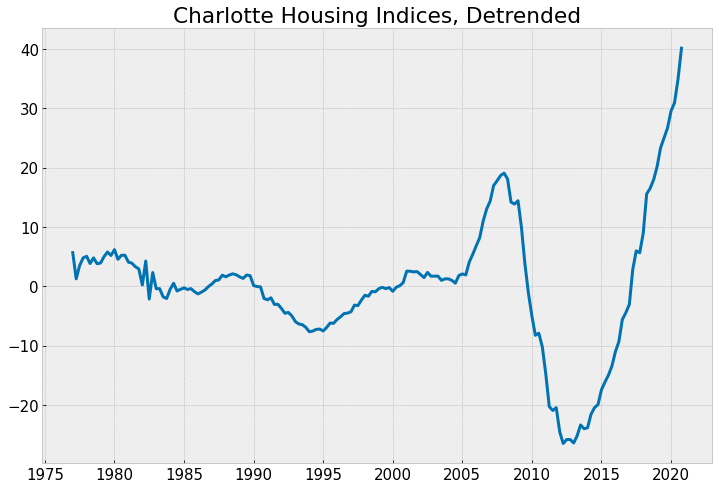

In [47]:
# Detrending the Charlotte Indices:

charlotte_series = charlotte_msa['index']
charlotte_linear_trend = fit_linear_trend(charlotte_series)

charlotte_series_detrended = charlotte_series - charlotte_linear_trend

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(charlotte_series_detrended.index, charlotte_series_detrended, linewidth=3)
ax.set_title('Charlotte Housing Indices, Detrended');

### Seasonal Decomposition

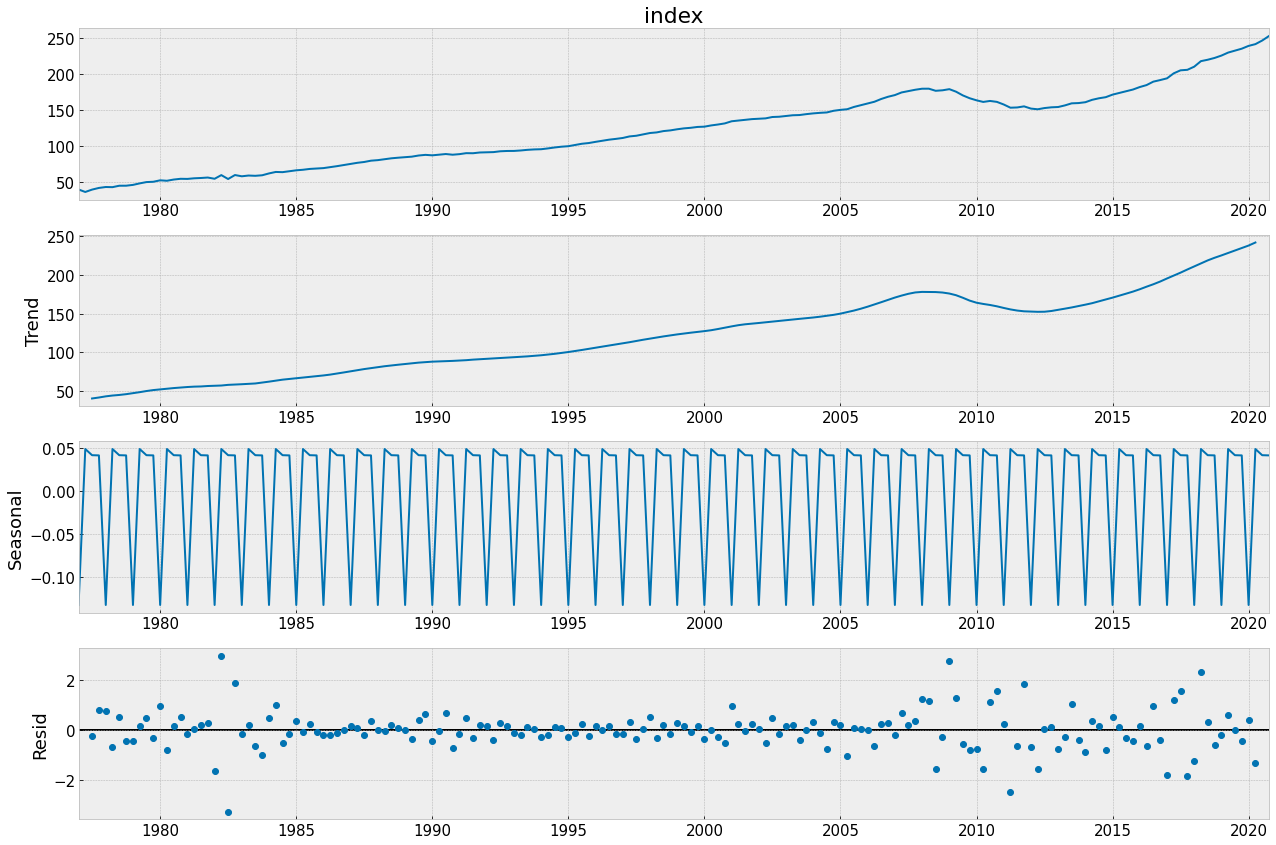

In [56]:
rcParams['figure.figsize'] = 18,12

decomp = seasonal_decompose(charlotte_msa['index'], model='additive')
decomp.plot();

In [57]:
'''
Another Dickey-Fuller test (though it's highly unlikely 
that it's stationary)

alpha = 0.5

H0 = the data are not stationary
HA = the data are stationary

'''

result = adfuller(charlotte_msa['index'])

print(f'The p-value of the test is {result[1]}')

The p-value of the test is 0.9964879709441662


Same deal as Denver, the data are not stationary... we fail to reject the null hypothesis.

## San Francisco

In [77]:
sf_msa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182 entries, 0 to 181
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DATE            182 non-null    object 
 1   ATNHPIUS41884Q  182 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.0+ KB


In [78]:
# renaming columns

sf_msa.rename(columns={'DATE':'date','ATNHPIUS41884Q':'index'}, inplace=True)
sf_msa['date'] = pd.to_datetime(sf_msa['date'], infer_datetime_format = True)
sf_msa.set_index(sf_msa['date'], inplace=True)

In [79]:
sf_msa.head()

,date,index
date,,
1975-07-01,1975-07-01,22.70
1975-10-01,1975-10-01,19.67
1976-01-01,1976-01-01,15.08
1976-04-01,1976-04-01,20.70
1976-07-01,1976-07-01,22.26


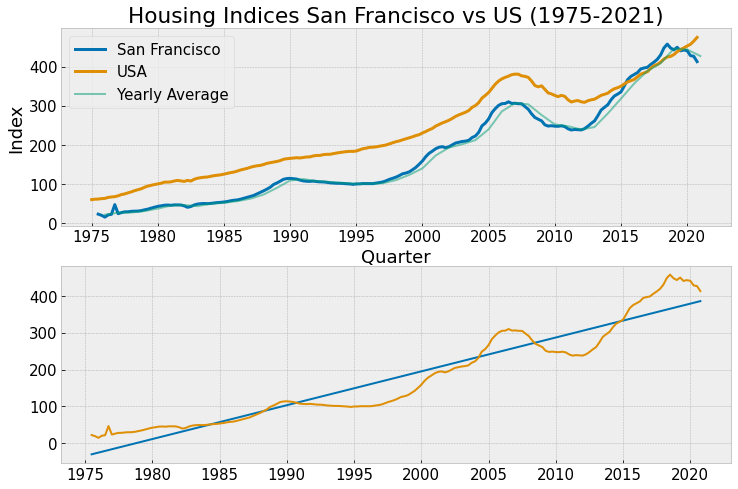

In [80]:
yearly = sf_msa['index'].resample('Y').mean()

fig, ax = plt.subplots(2, 1, figsize=(12,8))

ax[0].plot(sf_msa.index, sf_msa['index'], label="San Francisco", linewidth=3)
ax[0].plot(us_df.index, us_df['index'], label="USA", linewidth=3)
ax[0].plot(yearly, label='Yearly Average', alpha=0.5)
ax[0].set_xlabel('Quarter')
ax[0].set_ylabel('Index')
ax[0].set_title('Housing Indices San Francisco vs US (1975-2021)')
ax[0].legend()
plot_linear_trend(ax[1], 'San Francisco', sf_msa['index'])
ax[1].plot(sf_msa.index, sf_msa['index'])
plt.tight_layout;


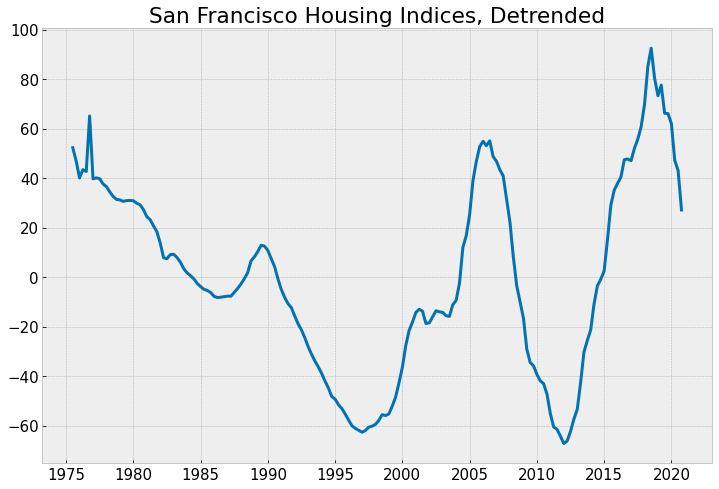

In [52]:
# Detrending SF indices:

sf_series = sf_msa['index']
sf_linear_trend = fit_linear_trend(sf_series)

sf_series_detrended = sf_series - sf_linear_trend

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(sf_series_detrended.index, sf_series_detrended, linewidth=3)
ax.set_title('San Francisco Housing Indices, Detrended');

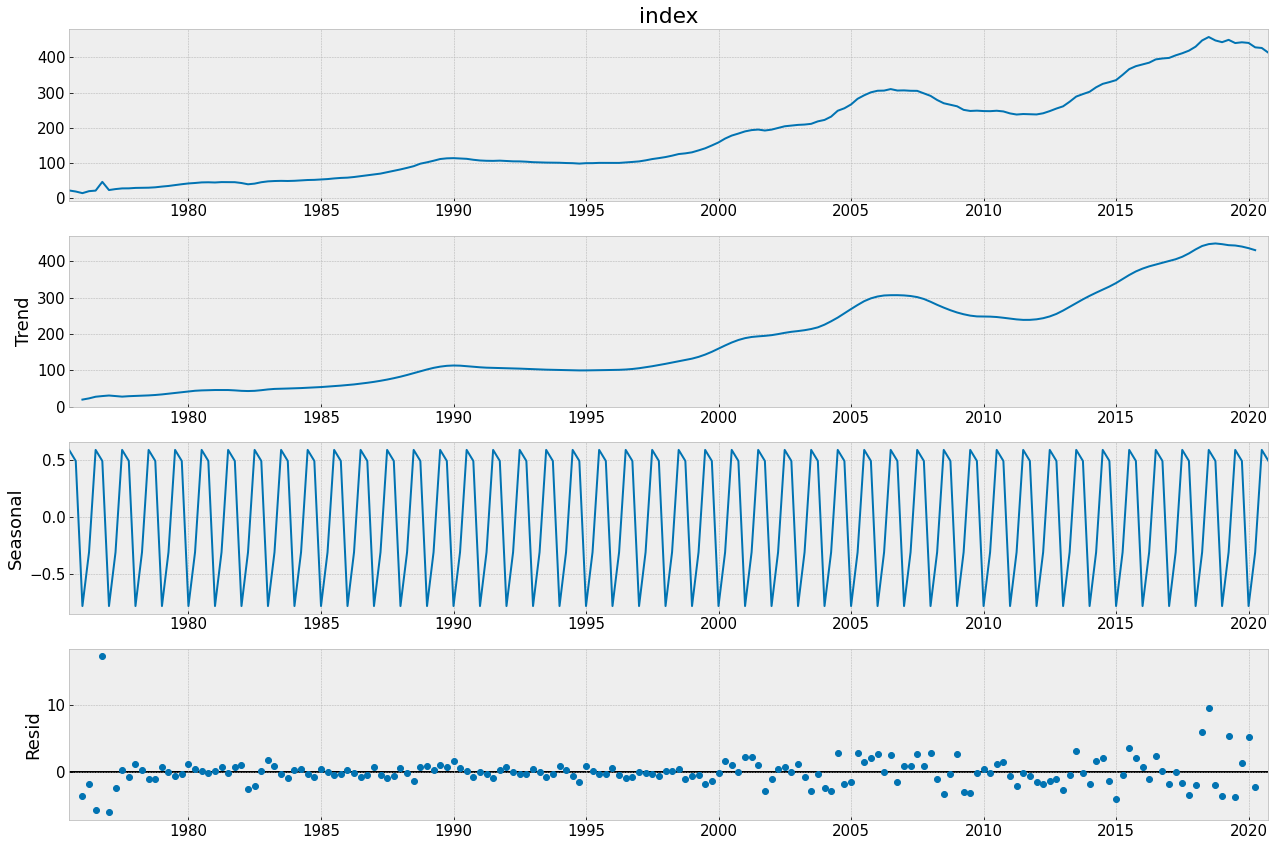

In [58]:
rcParams['figure.figsize'] = 18,12

decomp = seasonal_decompose(sf_msa['index'], model='additive')
decomp.plot();

In [59]:
'''
Another Dickey-Fuller test (though it's highly unlikely 
that it's stationary)

alpha = 0.5

H0 = the data are not stationary
HA = the data are stationary

'''

result = adfuller(sf_msa['index'])

print(f'The p-value of the test is {result[1]}')

The p-value of the test is 0.8238348713645964


Same deal here, the data are not stationary, we fail to reject the null hypothesis

## Nashville

In [81]:
nashville_msa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166 entries, 0 to 165
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DATE            166 non-null    object 
 1   ATNHPIUS34980Q  166 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.7+ KB


In [82]:
# renaming columns

nashville_msa.rename(columns={'DATE':'date','ATNHPIUS34980Q':'index'}, inplace=True)
nashville_msa['date'] = pd.to_datetime(nashville_msa['date'], infer_datetime_format = True)
nashville_msa.set_index(nashville_msa['date'], inplace=True)

In [83]:
nashville_msa.head()

,date,index
date,,
1979-07-01,1979-07-01,50.68
1979-10-01,1979-10-01,50.65
1980-01-01,1980-01-01,51.80
1980-04-01,1980-04-01,50.21
1980-07-01,1980-07-01,53.38


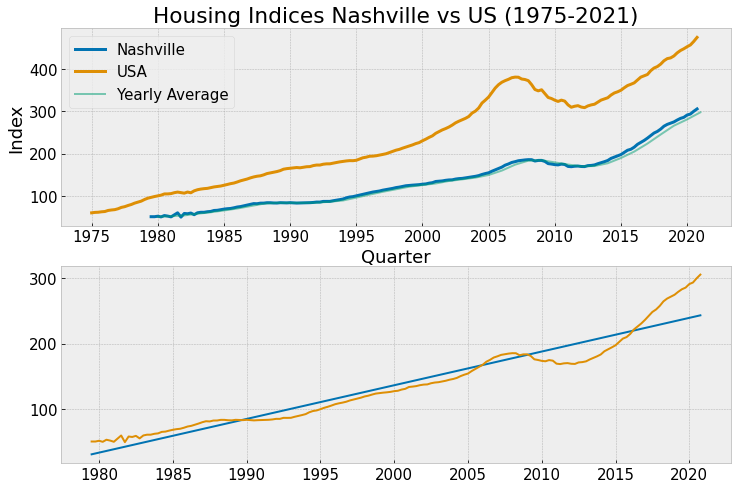

In [87]:
yearly = nashville_msa['index'].resample('Y').mean()

fig, ax = plt.subplots(2, 1, figsize=(12,8))

ax[0].plot(nashville_msa.index, nashville_msa['index'], label="Nashville", linewidth=3)
ax[0].plot(us_df.index, us_df['index'], label="USA", linewidth=3)
ax[0].plot(yearly, label='Yearly Average', alpha=0.5)
ax[0].set_xlabel('Quarter')
ax[0].set_ylabel('Index')
ax[0].set_title('Housing Indices Nashville vs US (1975-2021)')
ax[0].legend()
plot_linear_trend(ax[1], 'Nashville', nashville_msa['index'])
ax[1].plot(nashville_msa.index, nashville_msa['index'])
plt.tight_layout;


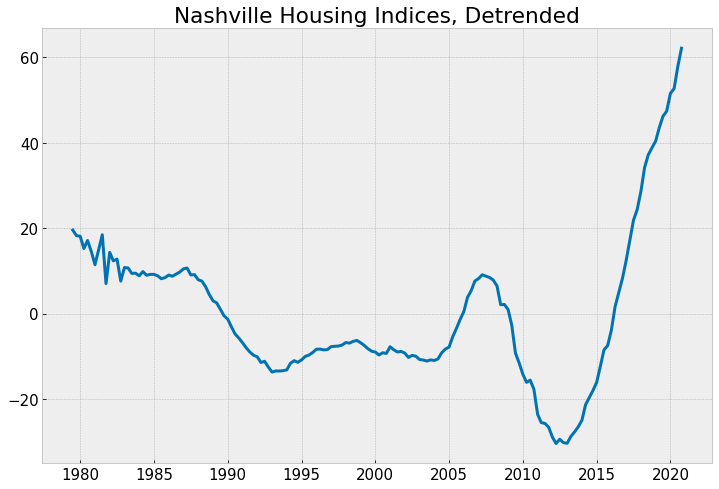

In [89]:
# Detrending the Nashville Indices:

nashville_series = nashville_msa['index']
nashville_linear_trend = fit_linear_trend(nashville_series)

nashville_series_detrended = nashville_series - nashville_linear_trend

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(nashville_series_detrended.index, nashville_series_detrended, linewidth=3)
ax.set_title('Nashville Housing Indices, Detrended');

In [91]:
# result = adfuller(nashville_series_detrended)

# print(f'The p-value of the test is {result[1]}')

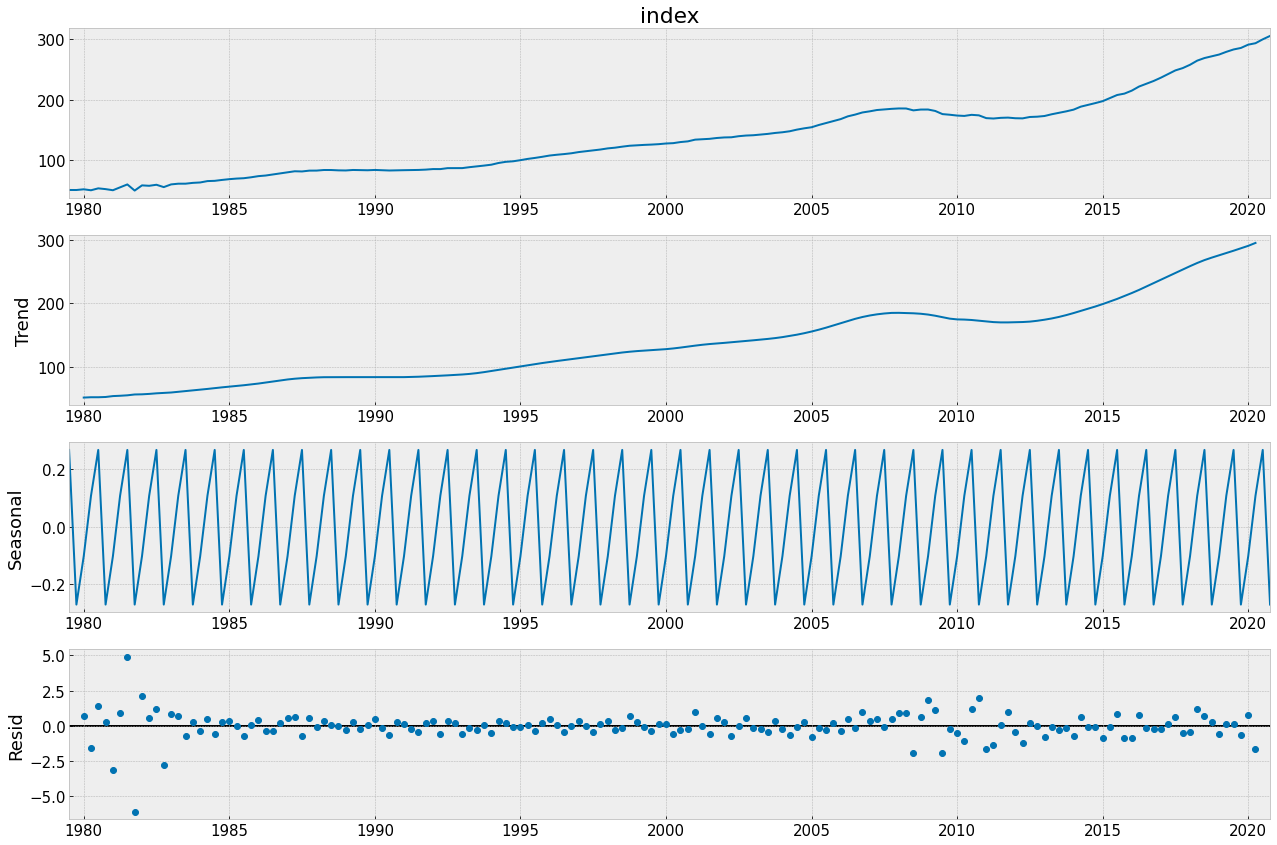

In [60]:
rcParams['figure.figsize'] = 18,12

decomp = seasonal_decompose(nashville_msa['index'], model='additive')
decomp.plot();

In [61]:
'''
Another Dickey-Fuller test (though it's highly unlikely 
that it's stationary)

alpha = 0.5

H0 = the data are not stationary
HA = the data are stationary

'''

result = adfuller(nashville_msa['index'])

print(f'The p-value of the test is {result[1]}')

The p-value of the test is 0.9982001132033588


Same deal here.. all of our indices are non-stationary. We fail to reject the null hypothesis. 

We could log transform all the data to make sure it better fits the requirement of the statistical test, but based on the visualizations and dickey-fuller results, it doesn't seem necessary to explore any further.

## Let's see them all stacked on top of one another

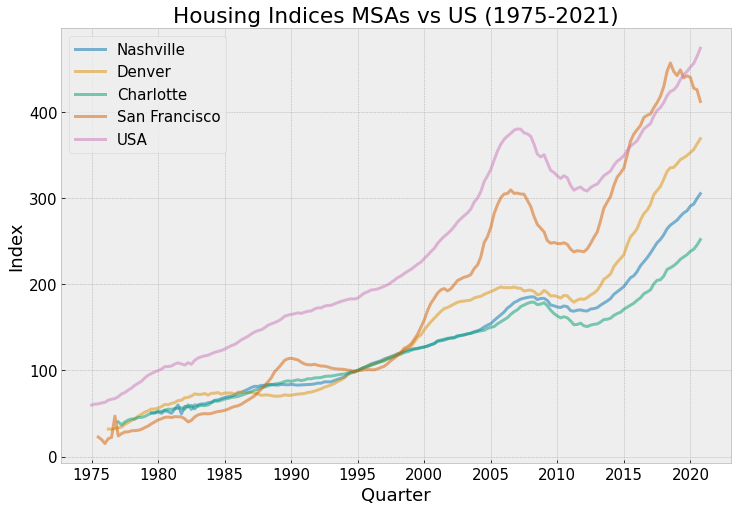

In [24]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(nashville_msa.index, nashville_msa['index'], label="Nashville", linewidth=3, alpha=0.5)
ax.plot(denver_msa.index, denver_msa['index'], label="Denver", linewidth=3, alpha=0.5)
ax.plot(charlotte_msa.index, charlotte_msa['index'], label="Charlotte", linewidth=3, alpha=0.5)
ax.plot(sf_msa.index, sf_msa['index'], label="San Francisco", linewidth=3, alpha=0.5)
ax.plot(us_df.index, us_df['index'], label="USA", linewidth=3, alpha=0.5)
ax.set_xlabel('Quarter')
ax.set_ylabel('Index')
ax.set_title('Housing Indices MSAs vs US (1975-2021)')
ax.legend();

## APPLY DIFFERENCING AND SEE IF THAT MAKES DATA STATIONARY